# Putting memory into context (effects)

In this notebook you'll find some R-code that can be used to analyze the data that we have collected. I will separately go over different phenomena that we can find in our data. You can see each of these as a different 'problem' that your model needs to solve.

My advice is to initially choose just one of these phenomena to focus on, and try to construct a model that fits with this effect. Then, you can start to build from there and focus on different aspects of the data to focus on. 

A note of advice: if you save your model output to a CSV, that is structured in exactly the same way as the 'real' data, you can simply run this code for your analysis and compare the outcomes. That way, you won't have to recode these analysis in python. 

In [23]:
## Here, I'm loading the packages that are used in the analysis
## if you don't have them yet, you can install them with install.packages("name")

library(plyr)      # for data wrangling, should be loaded before newer dplyr
library(dplyr)     # for data wrangling
library(ggplot2)   # for plotting
library(magrittr)  # for the pipe operatior %>%
library(knitr)     # for pretty tables in the notebook env.

library(lme4)      # for Linear mixed effects regression (lmer / lmm)
library(lmerTest)  # get p-values from lmers

# The function 'plottab()' takes data from different subjects, and computes averages across conditions.
# It also computes within-subject Confidence intervals, which give you 
# an idea of the variability of the data patterns across participants
# This helpers.R file defines that function, so we load it here
source('helpers.R')

### function to change plot size in jupytR
fig <- function(width, heigth){
    options(repr.plot.width = width, repr.plot.height = heigth)
}

## finally: load the data:
all_dat <- read.csv('real_data.csv')
## or, 
# all_dat <- read.csv('model_data.csv')

# then, get rid;  of the practice & outlier trials 
# (we don't need them anymore; & the model probably doesn't have any outliers)
all_dat %<>% filter(practice=='no', outlier==FALSE)


In [24]:
all_dat %>% head() # quick view of what is in the dataset

,X,student_nr,Block_nr,practice,quadrant,stimulus,prior,ts,repr_error,sub_id,⋯,outlier,ts_1,ts_2,ts_3,ts_4,ts_5,ts_6,ts_7,qrep,ts_stim
,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,⋯,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,17,s3162443,1,no,TR,Object_0262.jpg,p3,0.975,0.070,s341281,⋯,FALSE,0.975,0.675,0.825,0.600,0.750,0.750,0.825,rep,NA
2,18,s3162443,1,no,TR,Object_0239.jpg,p3,0.900,-0.020,s341281,⋯,FALSE,0.975,0.975,0.675,0.825,0.600,0.750,0.750,rep,NA
3,19,s3162443,1,no,BR,Object_0200.jpg,p1,0.450,-0.046,s341281,⋯,FALSE,0.900,0.975,0.975,0.675,0.825,0.600,0.750,swi,NA
4,20,s3162443,1,no,TR,Object_0257.jpg,p3,0.900,-0.096,s341281,⋯,FALSE,0.450,0.900,0.975,0.975,0.675,0.825,0.600,swi,NA
5,21,s3162443,1,no,BR,Object_0033.jpg,p1,0.750,-0.013,s341281,⋯,FALSE,0.900,0.450,0.900,0.975,0.975,0.675,0.825,swi,NA
6,22,s3162443,1,no,TR,Object_0375.jpg,p3,1.125,-0.133,s341281,⋯,FALSE,0.750,0.900,0.450,0.900,0.975,0.975,0.675,swi,NA


`summarise()` has grouped output by 'sub_id', 'prior'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'group', 'prior'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'prior'. You can override using the `.groups` argument.


,prior,ts,P,lower,upper
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,p1,0.450,0.1991671,0.1882769,0.2100573
2,p1,0.525,0.2076738,0.1994474,0.2159001
3,p1,0.600,0.1941647,0.1839807,0.2043487
4,p1,0.675,0.2013208,0.1925614,0.2100803
5,p1,0.750,0.1976736,0.1887063,0.2066409
6,p2,0.750,0.2016901,0.1937915,0.2095887


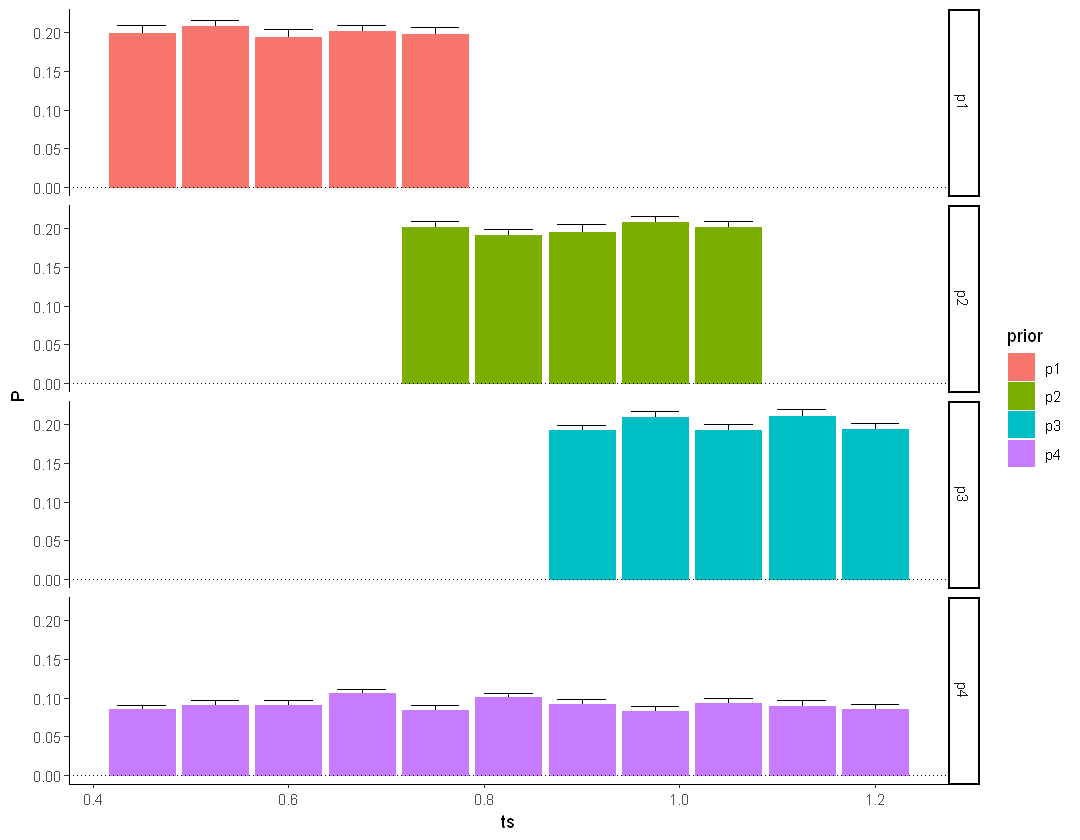

In [25]:
# + a quick plot of the priors:
## what is the prior? Per sub, count each interval in each condition
sub_pdat <- all_dat  %>% group_by(sub_id, prior, ts)  %>% summarize(n=n())

# then compute prob. per condition:
sub_pdat  %<>% group_by(sub_id,prior)  %>% mutate(P = n/sum(n))

# use plottab() to get the means and a sense of the variability 
Pdat <- sub_pdat  %>% plottab(gv=c('prior','ts'), dv='P', group='sub_id' )
Pdat %>% head() #just to illustrate

# then plot
Pdat  %>% ggplot(aes(x=ts,y=P,color=prior,fill=prior)) +
	geom_errorbar(aes(ymin=lower,ymax=upper), color='black',width=0.05) +  
	geom_bar(stat='identity') + facet_grid(prior~.) + 
	geom_hline(yintercept=0.0, color='black',linetype='dotted', size=0.5) +
	theme_classic()


# Central tendency effects per prior

First, we want to determine whether there was any effect of the prior on central tendency effects. For each participant, a different quadrant reflected a different prior. The assumption here was that these locations might each get associated with its prior, and affect reproductions accordingly.

The reproduction time tr will be affected by the sampled duration ts. If there are no effects of the prior at all, then that's just it. In that model there might still be central tendency effects, but they're not dependent on the prior (the context) that the interval is presented in. So let's plot these data, and then put this to the test.

`summarise()` has grouped output by 'sub_id', 'prior'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'group', 'prior'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'prior'. You can override using the `.groups` argument.
`geom_smooth()` using formula = 'y ~ x'


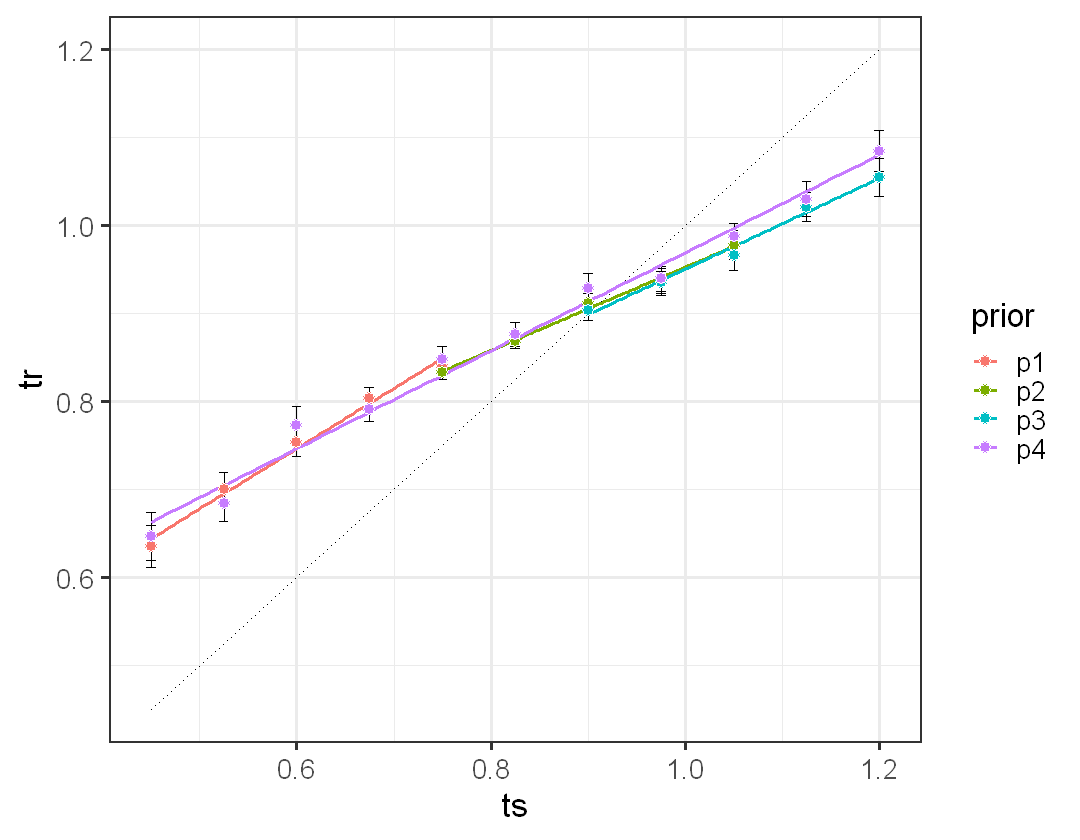

In [26]:

#### is there an effect of the prior?
# compute the average tr per ts, per participant
sub_ave <- all_dat %>% filter(outlier==FALSE)  %>% 
	group_by(sub_id, prior,ts) %>% summarize(tr=mean(tr))


gave <- sub_ave  %>% plottab(gv=c('prior','ts'),dv='tr',group='sub_id')

# make the plot
fig(9,7)  # set figure size:
gave  %>% ggplot(aes(x=ts,y=tr,color=prior,fill=prior)) + 
	geom_line(aes(x=ts,y=ts,group=1), color='black',linetype='dotted') +  # veridical 
	geom_errorbar(aes(ymin=lower,ymax=upper),color='black', width=0.01) + 
	#geom_line(linewidth=1) +                        # if you want lines that connect the data points, or:
	geom_smooth(linewidth=1, method='lm', se=F) +    # if you want linear fits
	geom_point(shape=21, color='white',size=3) + 
	theme_bw(base_size=20)


In [27]:
## ^^^ This doesn't look like there's much of an effect of the prior. What do the stats say?
## There are many ways to do statistical tests with lmers. Here, will do a simple anova on the effects
# terms of a 'complete' model.
# also, we look at the coefficients of the model.

# model where tr is affected by both ts and the prior:
#### fit models:
dd <- all_dat  %>% filter(outlier==FALSE)
M <- lmer(tr~ts*prior + (1|sub_id), data=dd)

# look at the effects:
print('Coefficients of the predictor terms')
summary(M) 

# anova on the effects as a whole:
print('Anova of the different predictors in the model:')
anova(M)

print('Model comparisons:')
## different way to test this; model comparison between a model with and without an effect of the prior:
m0 <- lmer(tr~ts + (1|sub_id), data=dd)
m1 <- lmer(tr~ts*prior + (1|sub_id), data=dd)
anova(m0, m1) # 3 statistical tests in one: 
# lower BIC is better
# lower AIC is better, 
# Significance means more complex model is preferred over the one above it (chi-sq/Likelihood ratio test)


[1] "Coefficients of the predictor terms"


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: tr ~ ts * prior + (1 | sub_id)
   Data: dd

REML criterion at convergence: -8584.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2006 -0.6220 -0.0189  0.5943  5.8190 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.02093  0.1447  
 Residual             0.03730  0.1931  
Number of obs: 19595, groups:  sub_id, 35

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  3.339e-01  2.918e-02  6.848e+01  11.440  < 2e-16 ***
ts           6.879e-01  2.616e-02  1.955e+04  26.294  < 2e-16 ***
priorp2      1.555e-01  2.838e-02  1.955e+04   5.480 4.31e-08 ***
priorp3      1.009e-01  3.195e-02  1.955e+04   3.158  0.00159 ** 
priorp4      8.302e-02  1.884e-02  1.955e+04   4.406 1.06e-05 ***
ts:priorp2  -2.264e-01  3.680e-02  1.955e+04  -6.151 7.84e-10 ***
ts:priorp3  -1.718e-01  3.706e-02  1.955e+04  -4.636 3.57e-06 *

[1] "Anova of the different predictors in the model:"


,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ts,83.950210,83.9502102,1,19553.21,2250.70843,0.000000e+00
prior,1.318531,0.4395102,3,19553.22,11.78328,1.043197e-07
ts:prior,1.532839,0.5109464,3,19553.24,13.69849,6.370860e-09


[1] "Model comparisons:"


refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m0,4,-8576.082,-8544.550,4292.041,-8584.082,NA,NA,NA
m1,10,-8622.032,-8543.202,4321.016,-8642.032,57.94981,6,1.173079e-10


In [28]:
# Somewhat surprisingly, there actually IS a strong effect of the prior. But, the effect doesn't resemble 
# the central tendency effect at all. Note that ts is coded as a linear predictor here, even though the 
# relation between ts and tr doesn't seem to be linear. The effect of the prior likely corresponds to the 
# effect of the slope changing for short v long durations.

# we'll test this by making ts a factorial variable (ignoring any slope-effects), then checking whether evidence for a prior-effect is still there.
dd <- all_dat  %>% filter(outlier==FALSE)
dd$ts %<>% as.factor
M <- lmer(tr~ts*prior + (1|sub_id), data=dd)

# look at the effects:
summary(M) 
print('-----------')
# anova on the effects as a whole:
anova(M)

## model comparison between a model with and without an effect of the prior:
m0 <- lmer(tr~ts + (1|sub_id), data=dd)
m1 <- lmer(tr~ts*prior + (1|sub_id), data=dd)
anova(m0, m1) # lower BIC or AIC is better, significance means a preferred, more complex model.



### below, you can see that the interaction effect (ts *prior) is completely gone. 

fixed-effect model matrix is rank deficient so dropping 18 columns / coefficients


Correlation matrix not shown by default, as p = 26 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: tr ~ ts * prior + (1 | sub_id)
   Data: dd

REML criterion at convergence: -8475.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2114 -0.6220 -0.0203  0.5956  5.8920 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.02094  0.1447  
 Residual             0.03727  0.1930  
Number of obs: 19595, groups:  sub_id, 35

Fixed effects:
                  Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)      6.358e-01  2.523e-02  3.829e+01  25.196  < 2e-16 ***
ts0.525          6.264e-02  8.691e-03  1.954e+04   7.207 5.91e-13 ***
ts0.6            1.167e-01  8.843e-03  1.954e+04  13.196  < 2e-16 ***
ts0.675          1.705e-01  8.757e-03  1.954e+04  19.474  < 2e-16 ***
ts0.75           2.040e-01  8.798e-03  1.954e+04  23.190  < 2e-16 ***
ts0.825          2.270e-01  1.283e-02  1.954e+04  17.694  < 2e-16 ***
ts0.9            2.762e-01  1.309e-

[1] "-----------"


Missing cells for: ts0.825:priorp1, ts0.9:priorp1, ts0.975:priorp1, ts1.05:priorp1, ts1.125:priorp1, ts1.2:priorp1, ts0.45:priorp2, ts0.525:priorp2, ts0.6:priorp2, ts0.675:priorp2, ts1.125:priorp2, ts1.2:priorp2, ts0.45:priorp3, ts0.525:priorp3, ts0.6:priorp3, ts0.675:priorp3, ts0.75:priorp3, ts0.825:priorp3.  
Interpret type III hypotheses with care.



,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ts,120.6258322,12.06258322,10,19535.24,323.6943223,0.00000000
prior,0.3688897,0.12296324,3,19535.06,3.2996666,0.01946454
ts:prior,0.3553228,0.02961023,12,19535.22,0.7945781,0.65667729


fixed-effect model matrix is rank deficient so dropping 18 columns / coefficients

refitting model(s) with ML (instead of REML)



,npar,AIC,BIC,logLik,deviance,Chisq,Df,Pr(>Chisq)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
m0,13,-8632.690,-8530.211,4329.345,-8658.690,NA,NA,NA
m1,28,-8621.936,-8401.211,4338.968,-8677.936,19.24616,15,0.202795


So, to conclude: unlike the J&S result, we don't find central tendency effects that are different per prior.
There is a global central tendency effect, and the slope of this graph flattens for larger intervals.

# Sequential effects in reproduction

Next, we will test whether the data from our experiment reveals sequential effects; that is, whether the intervals on previous trials affect the reproduction on the current trial. This is an effect that most memory models and theories would predict out-of-the-box, but the bayesian hypothesis doesn't immediately account for it.

In [29]:
### This time, we start with the statistical test, and then plot the coefficients of the model:
## The coefficients of the model give a better view of n-1 effect than the actual plots do.

dd <- all_dat  %>% filter(outlier==FALSE)
mf <- lmer(tr~ts*prior + ts_1 + ts_2 + ts_3 + ts_4 + ts_5 + ts_6 + ts_7 + (1|sub_id), data=dd,na.action='na.omit')
summary(mf)

anova(mf)



Correlation matrix not shown by default, as p = 15 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: tr ~ ts * prior + ts_1 + ts_2 + ts_3 + ts_4 + ts_5 + ts_6 + ts_7 +  
    (1 | sub_id)
   Data: dd

REML criterion at convergence: -8690.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.2946 -0.6166 -0.0177  0.5942  5.7639 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.02101  0.1449  
 Residual             0.03700  0.1924  
Number of obs: 19595, groups:  sub_id, 35

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  2.087e-01  3.257e-02  1.055e+02   6.408 4.22e-09 ***
ts           6.895e-01  2.606e-02  1.955e+04  26.458  < 2e-16 ***
priorp2      1.584e-01  2.827e-02  1.955e+04   5.605 2.11e-08 ***
priorp3      1.034e-01  3.182e-02  1.955e+04   3.249 0.001160 ** 
priorp4      8.569e-02  1.877e-02  1.955e+04   4.564 5.04e-06 ***
ts_1         7.251e-02  6.226e-03  1.955e+04  11.646  < 2e-16 ***
ts_2    

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ts,83.84001503,83.84001503,1,19546.21,2265.9343565,0.000000e+00
prior,1.37825553,0.45941851,3,19546.22,12.4166507,4.142862e-08
ts_1,5.01810181,5.01810181,1,19546.08,135.6236552,3.058606e-31
ts_2,0.48341008,0.48341008,1,19546.09,13.0650682,3.016099e-04
ts_3,0.51327122,0.51327122,1,19546.07,13.8721217,1.962297e-04
ts_4,0.14689091,0.14689091,1,19546.09,3.9700035,4.633156e-02
ts_5,0.03856462,0.03856462,1,19546.09,1.0422816,3.073041e-01
ts_6,0.02641297,0.02641297,1,19546.09,0.7138604,3.981756e-01
ts_7,0.01553890,0.01553890,1,19546.10,0.4199682,5.169605e-01


No id variables; using all as measure variables

`summarise()` has grouped output by 'group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'group'. You can override using the `.groups` argument.


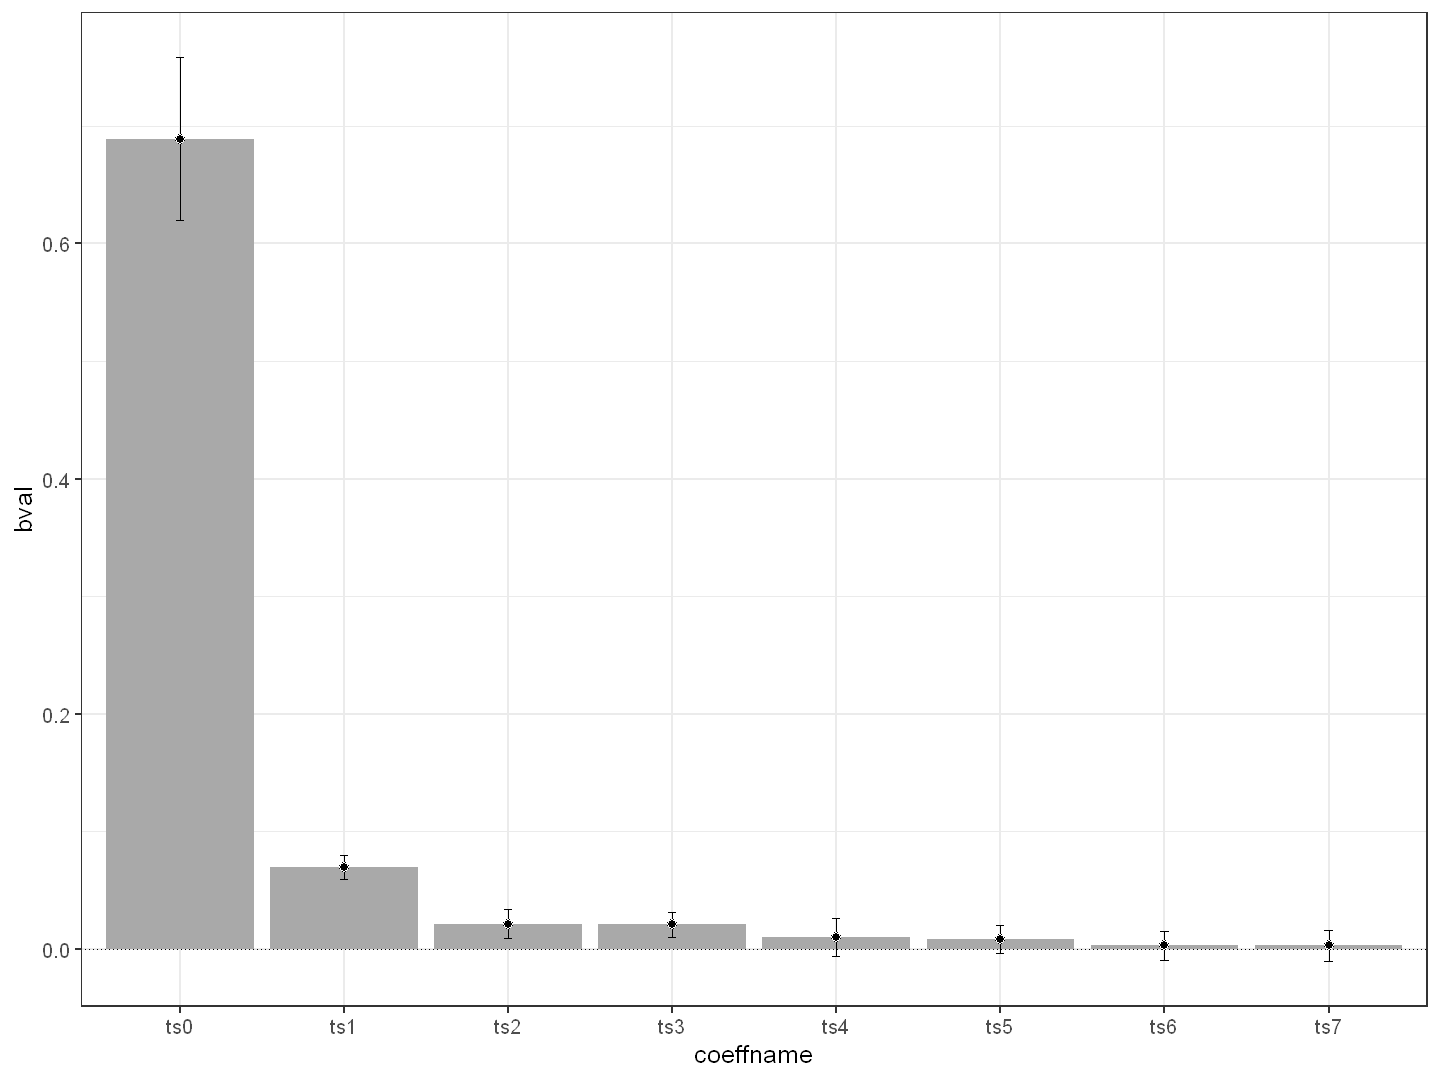

In [30]:
# The t-values of each individual effect show that there up to n-4,
# preceding trials significant effects on reproductions. For n-5,6,7 the trend continues.
# These effects are significant, but they're also rather small.

# To plot these, we'll make a table with the effect per-subject. That should closely correspond to the average, but it allows us to get a sense how much these effects vary across subjects:
# To fit an individual lm per subject, we use lmList(), then extract (and plot) the coefficients of each linear model

# list of lm's:
mf <- lmList(tr~ts*prior + ts_1 + ts_2 + ts_3 + ts_4 + ts_5 + ts_6 + ts_7 |sub_id, data=dd)
# extract coefficients, then extract only 'ts' coefficients, then turn into long format:
mf  %<>% coefficients  %>% data.frame  %>% .[,c(2,seq(6,12))]  %>% melt

# add subject id's back into this table:
mf$sub_id <- rep(seq(1,35), 8)  %>% as.factor
names(mf) <- c('coeffname','bval','sub_id')

# plottab function won't handle '_' in factor levels well. Get rid of them:
levels(mf$coeffname) <- paste0('ts',seq(0,7))
gave <- mf %>% plottab(dv='bval',gv=c('coeffname'), group='sub_id')

## plot coeffcients, usig a bar chart:

fig(12,9)
gave <- mf %>% plottab(dv='bval',gv=c('coeffname'), group='sub_id')
gave  %>% ggplot(aes(x=coeffname,y=bval,group=1)) + 
	geom_hline(yintercept=0.0,linetype='dotted',linewidth=0.5) +
	geom_bar(stat='identity',fill='darkgray') +
	geom_errorbar(aes(ymin=lower,ymax=upper),color='black',width=0.05) + 
	geom_point(size=2.5,shape=21,color='white',fill='black') + 
	theme_bw(base_size=15)



The plot does _not_ show the relative effect of the prior on the reproductions here. Roughly, you can see that the beta-value (coefficient) of ts itself is around .7, and of ts_1 is around .07 (so ~10% of that). This shows the relative effect of the current and previous ts on reproductions. The ts on trials further back have a minor, but positive effect on reproductions.  

# The effects of location

The effects thus far suggest that reproductions simply are affected by history, and that the different locations (and the four different priors) do not have a big effect on the reproductions. Here, we explore whether a) there is any effect of the location at all, and b) whether the sequential effect of ts_1 plotted above is modulated by location repetition. 

In [31]:
Mquad <- lmer(tr~ts*prior + quadrant + ts_1*qrep + (1|sub_id), data=dd, na.action='na.omit' )
summary(Mquad)
anova(Mquad)



Correlation matrix not shown by default, as p = 14 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: tr ~ ts * prior + quadrant + ts_1 * qrep + (1 | sub_id)
   Data: dd

REML criterion at convergence: -8698.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.1875 -0.6152 -0.0161  0.5932  5.7133 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.02098  0.1448  
 Residual             0.03699  0.1923  
Number of obs: 19595, groups:  sub_id, 35

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   2.403e-01  3.137e-02  9.097e+01   7.662 1.91e-11 ***
ts            6.878e-01  2.606e-02  1.955e+04  26.391  < 2e-16 ***
priorp2       1.532e-01  2.830e-02  1.955e+04   5.414 6.22e-08 ***
priorp3       1.011e-01  3.190e-02  1.955e+04   3.169  0.00153 ** 
priorp4       8.345e-02  1.881e-02  1.955e+04   4.436 9.23e-06 ***
quadrantBR    9.710e-03  3.954e-03  1.955e+04   2.456  0.01407 *  
quadrantTL   -5.643e-05  3.972e

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ts,83.9662764,83.9662764,1,19547.21,2269.763415,0.000000e+00
prior,1.2903135,0.4301045,3,19547.22,11.626518,1.310870e-07
quadrant,0.3928975,0.1309658,3,19547.01,3.540248,1.398059e-02
ts_1,4.1379097,4.1379097,1,19547.08,111.855335,4.520643e-26
qrep,0.3076116,0.3076116,1,19547.16,8.315310,3.935519e-03
ts:prior,1.5183765,0.5061255,3,19547.23,13.681506,6.531108e-09
ts_1:qrep,0.1316277,0.1316277,1,19547.18,3.558139,5.926893e-02


The results suggest that, even if we consider the _prior_, it turns out that the actual _location_ that an item is presented will also affect reproductions. From the coefficients, it seems that with respect to stimuli in the bottom-left, participants make longer reproductions in the bottom-right, and shorter ones in the top left and top-right. Again, these effects are small, but do hint that location matters:

In addition, we see that repeated locations affect temporal reproductions: reproductions are a bit longer whenever the location changes.

Finally, we see that there is a hint of an interaction between the previous ts and the previous quadrant.

Below, we plot the effect of quadrant on reproductions. Note that we cannot plot error bars here, because not every participant has ever seen certain durations in some of the quadrants. The differences are small, but at almost every ts the items presented in the BL show longer reproduction times. 
Subsequently, we plot the effect of whether the quadrant repeats or not. Repeating stimulus locations lead to shorter reproductions. And even though this isn't significant in the statistical model, it seems that this primarily affects shorter interval durations.


`summarise()` has grouped output by 'sub_id', 'quadrant'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'quadrant'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sub_id', 'qrep'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'qrep'. You can override using the `.groups` argument.


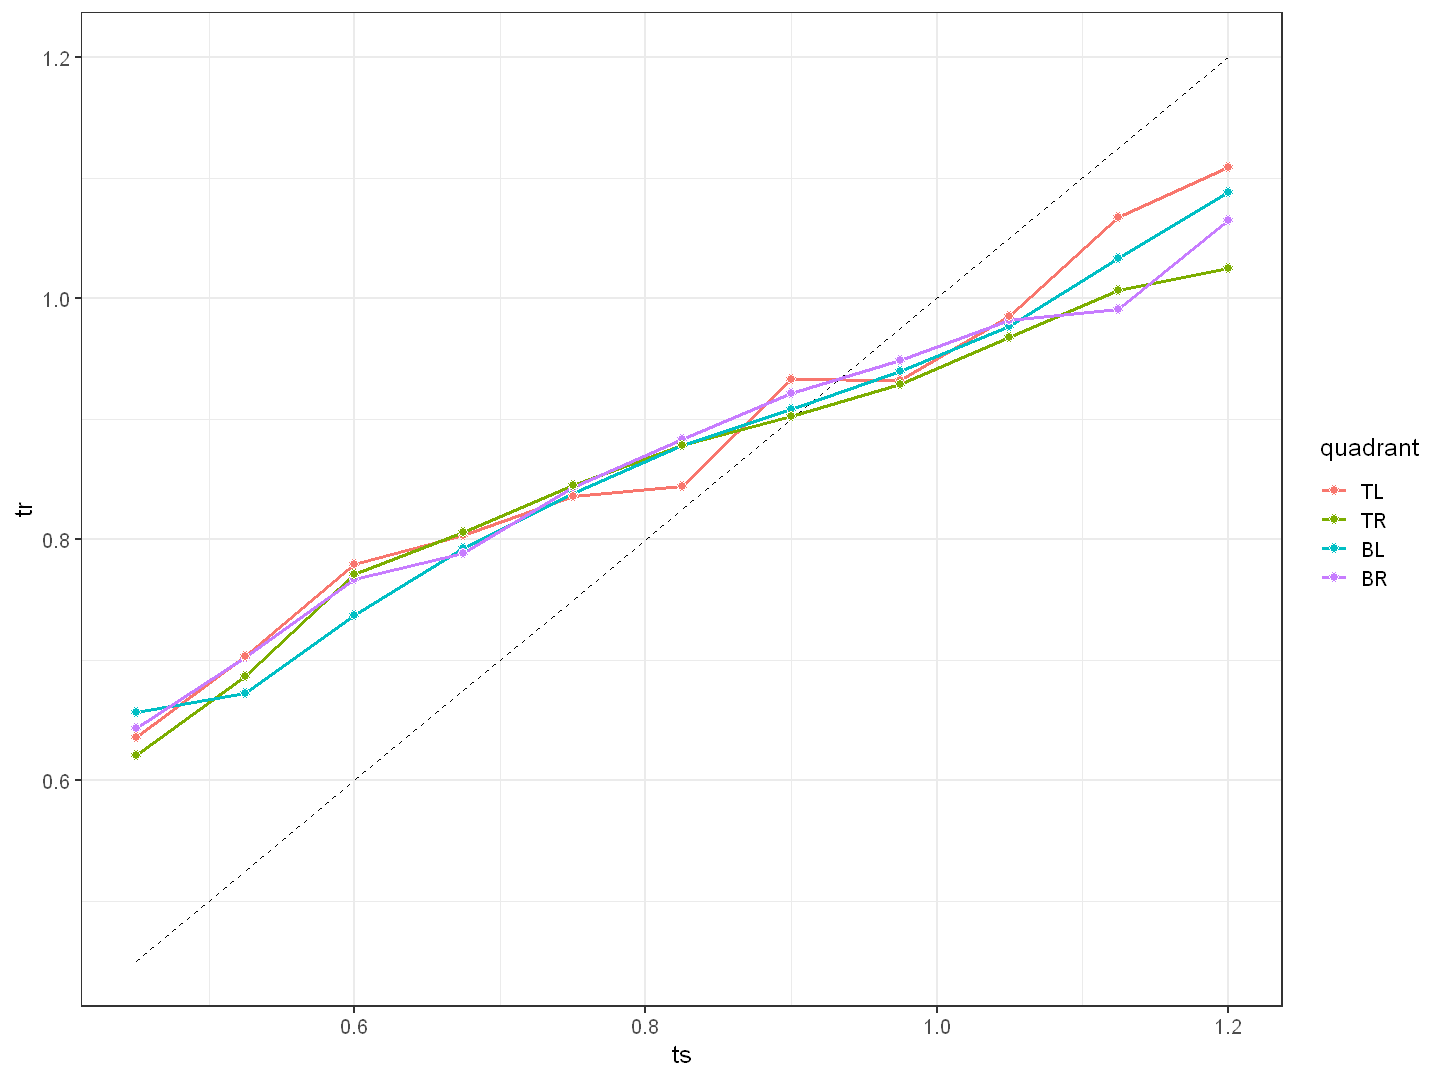

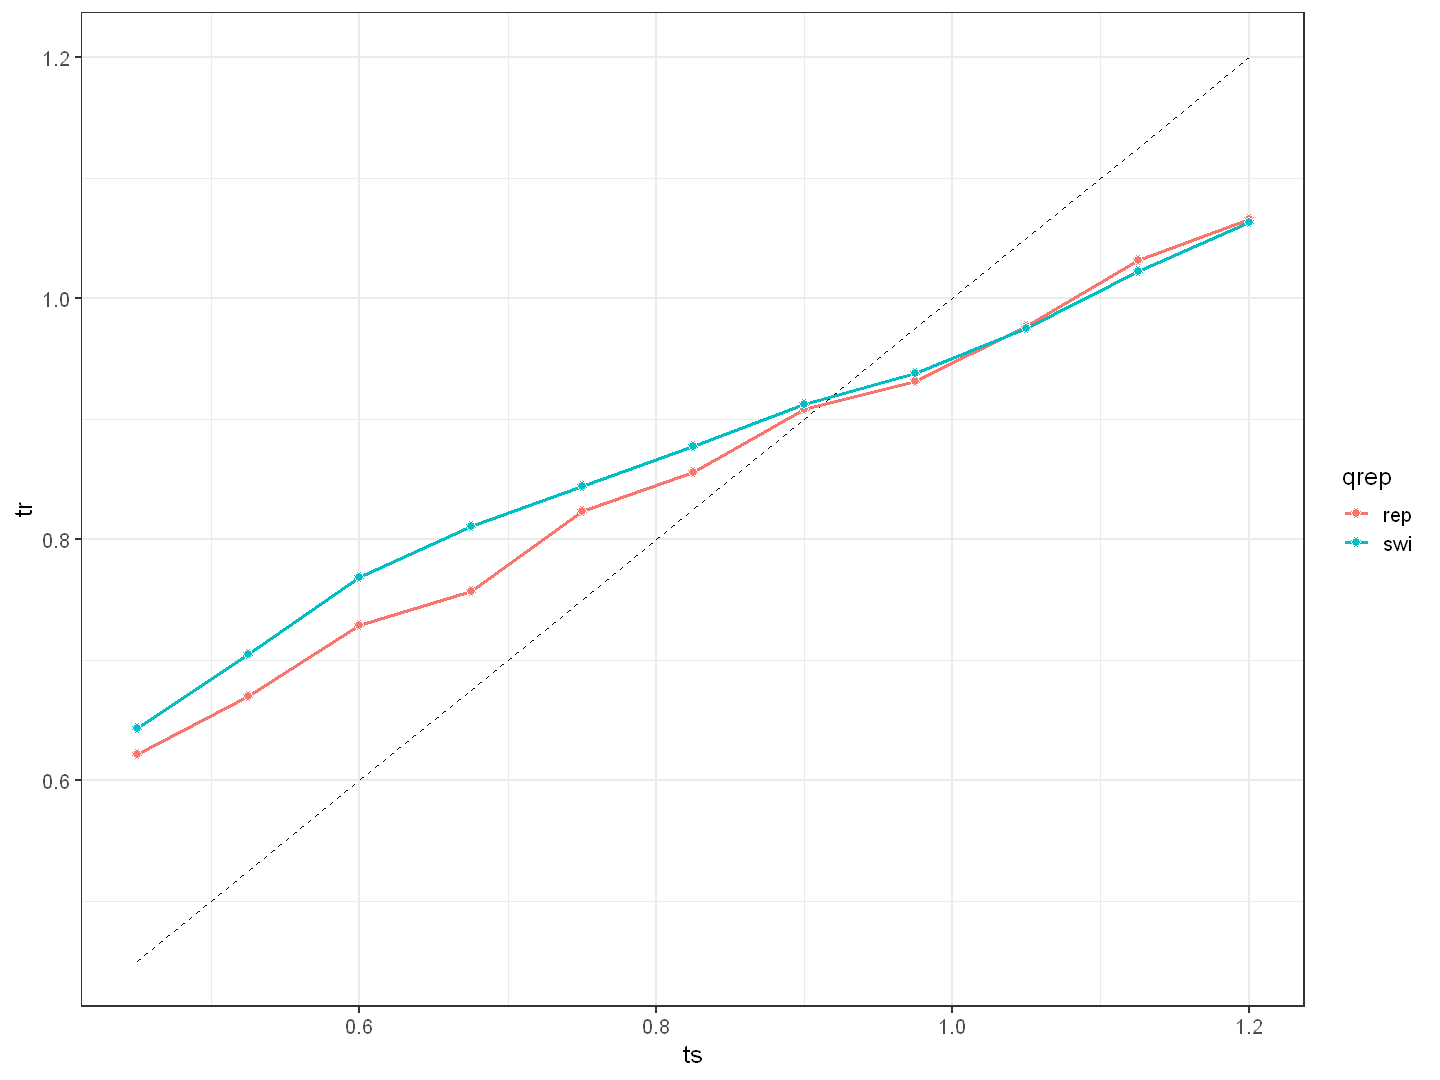

In [32]:
sub_ave <- all_dat %>% filter(outlier==FALSE)  %>% 
	group_by(sub_id, quadrant,ts) %>% summarize(tr=mean(tr))
gave <- sub_ave  %>% group_by(quadrant,ts)  %>% 
	summarize(tr=mean(tr))

# change factor order to something intuitive
gave$quadrant  %<>% factor(levels=c('TL','TR','BL','BR'))

gave  %>% ggplot(aes(x=ts,y=tr,color=quadrant,fill=quadrant)) + 
	geom_line(aes(x=ts,y=ts,group=1), color='black',linetype='dashed') + 
	geom_line(linewidth=1) + 
	geom_point(shape=21, color='white',size=2.5) + theme_bw(base_size=15)

## in a similar way, we can visualize the effect of location repetitions (qrep):
sub_ave <- all_dat %>% filter(outlier==FALSE)  %>% 
	group_by(sub_id, qrep,ts) %>% summarize(tr=mean(tr))
gave <- sub_ave  %>% group_by(qrep,ts)  %>% 
	summarize(tr=mean(tr))
gave  %<>% filter(!is.na(qrep))
gave  %>% ggplot(aes(x=ts,y=tr,color=qrep,fill=qrep)) + 
	geom_line(aes(x=ts,y=ts,group=1), color='black',linetype='dashed') + 
	geom_line(linewidth=1) + 
	geom_point(shape=21, color='white',size=2.5) + theme_bw(base_size=15)



# Item repetitions

One of the research questions we had at the start of this project was whether reproductions are not only affected by recent memories, but also by unique, individual memories that are longer ago and associated with individual, recognizable objects. To this end, the objects presented in odd blocks, were repeated in even blocks. However, the durations of items in odd blocks did not seem to affect their reproductions in even blocks: 

In [33]:
#### Look only at even blocks: do associated stim durations (ts_stim) affect tr?
dd <- all_dat  %>% filter(outlier==FALSE,Block_nr %in% seq(2,12,2))
m_mem <- lmer(tr~ts*prior + ts_stim + (1|sub_id), data=dd)
summary(m_mem)
anova(m_mem)


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: tr ~ ts * prior + ts_stim + (1 | sub_id)
   Data: dd

REML criterion at convergence: -4043.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9324 -0.6218 -0.0207  0.6111  4.9087 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub_id   (Intercept) 0.02093  0.1447  
 Residual             0.03788  0.1946  
Number of obs: 9811, groups:  sub_id, 35

Fixed effects:
              Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)  3.327e-01  3.444e-02  1.316e+02   9.660  < 2e-16 ***
ts           6.939e-01  3.784e-02  9.769e+03  18.337  < 2e-16 ***
priorp2      1.214e-01  4.077e-02  9.769e+03   2.978 0.002906 ** 
priorp3      1.248e-01  4.549e-02  9.769e+03   2.743 0.006099 ** 
priorp4      8.949e-02  2.714e-02  9.769e+03   3.297 0.000981 ***
ts_stim      6.477e-03  8.907e-03  9.768e+03   0.727 0.467133    
ts:priorp2  -1.969e-01  5.304e-02  9.769e+03  -3.711 0

,Sum Sq,Mean Sq,NumDF,DenDF,F value,Pr(>F)
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
ts,41.4242703,41.4242703,1,9768.422,1093.4960262,2.140069e-227
prior,0.5739161,0.1913054,3,9768.483,5.0499783,1.701656e-03
ts_stim,0.0200319,0.0200319,1,9768.170,0.5287915,4.671328e-01
ts:prior,0.7595709,0.2531903,3,9768.488,6.6835842,1.672317e-04


These results suggest that ts_stim does not have a strong effect on reproductions (although the coefficient is pointing in the right direction). This suggests that memories of durations are either not associated with stimulus identity, or that these memories are simply not contributing much to duration reproductions (for example, they might be too distant to be retrieved).

Although we don't have data on this, you may choose to solve an additional problem here with your model: namely, how can it be that these memories don't have a (strong) effect on reproductions, while at the same time you, as a participant, were presumably aware that these stimuli had been presented before. So, somehow you had a memory for these stimuli, but it didn't affect your reproductions.